In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gemma-language-tuning/submission_instructions.txt


In [3]:
! pip install transformers

In [1]:
! pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 5.1 MB/s eta 0:00:00ta 0:00:01


In [2]:
! pip install transformers Accelerate

In [3]:
! pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 11.5 MB/s eta 0:00:0000:0100:01


In [4]:
! pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 53.1 MB/s eta 0:00:00:00:0100:01


In [5]:
! pip install torch 

In [6]:
! pip install pyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.1 MB/s eta 0:00:00


In [7]:
! pip install nltk

In [8]:
! pip install watermark 

In [10]:
! pip install accelerate deepspeed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.5 MB/s eta 0:00:00
  Created wheel for deepspeed: filename=deepspeed-0.15.3-py3-none-any.whl size=1526083 sha256=50efee19c80ed1d2896ebf9ac2369c5638a98b25abecb760db34374cd46ab921
  Stored in directory: /root/.cache/pip/wheels/b3/c2/9f/37a2c813b8d64d7908793319cfdfa4f852754e177f20f0b858
Successfully built deepspeed


In [11]:
!pip install transformers sentence_transformers faiss-cpu torch PyPDF2 nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 7.7 MB/s eta 0:00:00


In [12]:
# Import of libraries

# System libraries
import re
import unicodedata
import itertools
from datasets import Dataset

# Library for file manipulation
import pandas as pd
import numpy as np
import pandas

# Data visualization
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt

# Configuration for graph width and layout
sns.set_theme(style='whitegrid')
palette='viridis'

## LLM
# Importing necessary libraries from PyTorch and Hugging Face Transformers
# PyTorch is a deep learning framework used for model training and inference
import torch  

# AutoTokenizer: Automatically loads a pre-trained tokenizer for encoding text
# AutoModelForCausalLM: Loads a pre-trained model for causal language modeling (e.g., for text generation)
# pipeline: Provides an easy-to-use interface to perform tasks like text generation, sentiment analysis, etc.
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sentence_transformers import SentenceTransformer

# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")

# Python version
from platform import python_version
print('Python version in this Jupyter Notebook:', python_version())

# Load library versions
import watermark

# Library versions
%reload_ext watermark
%watermark -a "Library versions" --iversions

Python version in this Jupyter Notebook: 3.10.14
Author: Library versions

plotly               : 5.22.0
platform             : 1.0.8
datasets             : 3.0.1
matplotlib           : 3.7.5
torch                : 2.4.0+cpu
seaborn              : 0.12.2
watermark            : 2.5.0
re                   : 2.2.1
numpy                : 1.26.4
pandas               : 2.2.3
sentence_transformers: 3.2.1
transformers         : 4.45.1



In [8]:
! pip install yfinance ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=4667c187c559fbd5d297247a49c922d79ad3d8e39cc903126470167194487f0f
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [9]:
import yfinance as yf
import pandas as pd
import ta

# Define the ticker symbol for Bitcoin
ticker_symbol = 'BTC-USD'

# Get data on this ticker
btc_data = yf.Ticker(ticker_symbol)

# Get historical market data for the last 10 years
btc_historical_data = btc_data.history(period='10y')

# Calculate technical indicators
btc_historical_data['SMA_50'] = ta.trend.sma_indicator(btc_historical_data['Close'], window=50)
btc_historical_data['SMA_200'] = ta.trend.sma_indicator(btc_historical_data['Close'], window=200)
btc_historical_data['RSI'] = ta.momentum.rsi(btc_historical_data['Close'], window=14)
btc_historical_data['MACD'] = ta.trend.macd(btc_historical_data['Close'])
btc_historical_data['Bollinger_High'] = ta.volatility.bollinger_hband(btc_historical_data['Close'])
btc_historical_data['Bollinger_Low'] = ta.volatility.bollinger_lband(btc_historical_data['Close'])

# Save the data with indicators to a CSV file
btc_historical_data.to_csv('bitcoin_10_years_data_with_indicators.csv')

print("Data with indicators saved to bitcoin_10_years_data_with_indicators.csv")


Data with indicators saved to bitcoin_10_years_data_with_indicators.csv


In [22]:
import pandas as pd

# Read the CSV file into a DataFrame
btc_df_indicators = pd.read_csv('bitcoin_10_years_data_with_indicators.csv')



In [23]:
btc_df_indicators  

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_50,SMA_200,RSI,MACD,Bollinger_High,Bollinger_Low
0,2014-11-07 00:00:00+00:00,349.817993,352.731995,341.776001,342.415009,16834200,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-11-08 00:00:00+00:00,342.153992,347.032013,342.153992,345.488007,8535470,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-11-09 00:00:00+00:00,345.376007,363.626007,344.255005,363.264008,24205600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-11-10 00:00:00+00:00,362.265015,374.816010,357.561005,366.924011,30450100,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-11-11 00:00:00+00:00,365.856995,371.309998,363.734985,367.695007,15838900,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2024-11-02 00:00:00+00:00,69486.023438,69867.351562,69033.718750,69289.273438,18184612091,0.0,0.0,64815.633203,63412.417422,57.081107,1712.945111,71969.013824,64905.651020
3649,2024-11-03 00:00:00+00:00,69296.382812,69361.656250,67482.523438,68741.117188,34868307655,0.0,0.0,64990.353125,63449.739551,54.895359,1552.702203,71929.912603,65214.251460
3650,2024-11-04 00:00:00+00:00,68742.132812,69433.179688,66803.648438,67811.507812,41184819348,0.0,0.0,65162.926562,63471.233320,51.307236,1335.304280,71914.540540,65306.663367
3651,2024-11-05 00:00:00+00:00,67811.171875,70522.789062,67458.867188,69359.562500,46046889204,0.0,0.0,65386.267656,63498.813281,56.416141,1273.252671,71984.055787,65411.832494


In [14]:
import yfinance as yf
import pandas as pd
import requests

# Define the ticker symbol for Bitcoin
ticker_symbol = 'BTC-USD'

# Get data on this ticker
btc_data = yf.Ticker(ticker_symbol)

# Get historical market data for the last 10 years
btc_historical_data = btc_data.history(period='10y')

# Convert the index to timezone-naive
btc_historical_data.index = btc_historical_data.index.tz_localize(None)

# Fetch historical Fear & Greed Index data
url = 'https://api.alternative.me/fng/?limit=3650'
response = requests.get(url)
data = response.json()

# Convert the sentiment data to a DataFrame
sentiment_data = pd.DataFrame(data['data'])
sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'], unit='s')

# Convert the timestamp to timezone-naive
sentiment_data['timestamp'] = sentiment_data['timestamp'].dt.tz_localize(None)
sentiment_data.set_index('timestamp', inplace=True)

# Merge the sentiment data with the historical Bitcoin data
btc_historical_data = btc_historical_data.merge(sentiment_data, left_index=True, right_index=True, how='left')

# Save the combined data to a CSV file
btc_historical_data.to_csv('bitcoin_10_years_data_with_sentiment.csv')

print("Data with sentiment saved to bitcoin_10_years_data_with_sentiment.csv")


Data with sentiment saved to bitcoin_10_years_data_with_sentiment.csv


/tmp/ipykernel_30/1839060589.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'], unit='s')


In [18]:

# Read the CSV file into a DataFrame
btc_df_Sentiment = pd.read_csv('bitcoin_10_years_data_with_sentiment.csv')

In [19]:
btc_df_Sentiment

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,value,value_classification,time_until_update
0,2014-11-07,349.817993,352.731995,341.776001,342.415009,16834200,0.0,0.0,NaN,NaN,NaN
1,2014-11-08,342.153992,347.032013,342.153992,345.488007,8535470,0.0,0.0,NaN,NaN,NaN
2,2014-11-09,345.376007,363.626007,344.255005,363.264008,24205600,0.0,0.0,NaN,NaN,NaN
3,2014-11-10,362.265015,374.816010,357.561005,366.924011,30450100,0.0,0.0,NaN,NaN,NaN
4,2014-11-11,365.856995,371.309998,363.734985,367.695007,15838900,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3648,2024-11-02,69486.023438,69867.351562,69033.718750,69289.273438,18184612091,0.0,0.0,72.0,Greed,NaN
3649,2024-11-03,69296.382812,69361.656250,67482.523438,68741.117188,34868307655,0.0,0.0,74.0,Greed,NaN
3650,2024-11-04,68742.132812,69433.179688,66803.648438,67811.507812,41184819348,0.0,0.0,70.0,Greed,NaN
3651,2024-11-05,67811.171875,70522.789062,67458.867188,69359.562500,46046889204,0.0,0.0,70.0,Greed,NaN


In [29]:
import pandas as pd

# Assuming btc_df_Sentiment and btc_df_indicators are your DataFrames
# Ensure the 'Date' column is in datetime format and timezone-naive
btc_df_Sentiment['Date'] = pd.to_datetime(btc_df_Sentiment['Date']).dt.tz_localize(None)
btc_df_indicators['Date'] = pd.to_datetime(btc_df_indicators['Date']).dt.tz_localize(None)

# Merge the DataFrames on the 'Date' column
combined_df = pd.merge(btc_df_Sentiment, btc_df_indicators, on='Date', how='inner')

# Display the first few rows of the combined DataFrame
print(combined_df.head())


        Date      Open_x      High_x       Low_x     Close_x  Volume_x  \
0 2014-11-07  349.817993  352.731995  341.776001  342.415009  16834200   
1 2014-11-08  342.153992  347.032013  342.153992  345.488007   8535470   
2 2014-11-09  345.376007  363.626007  344.255005  363.264008  24205600   
3 2014-11-10  362.265015  374.816010  357.561005  366.924011  30450100   
4 2014-11-11  365.856995  371.309998  363.734985  367.695007  15838900   

   Dividends_x  Stock Splits_x  value value_classification  ...  Volume_y  \
0          0.0             0.0    NaN                  NaN  ...  16834200   
1          0.0             0.0    NaN                  NaN  ...   8535470   
2          0.0             0.0    NaN                  NaN  ...  24205600   
3          0.0             0.0    NaN                  NaN  ...  30450100   
4          0.0             0.0    NaN                  NaN  ...  15838900   

   Dividends_y  Stock Splits_y  SMA_50  SMA_200  RSI  MACD  Bollinger_High  \
0          0.0

In [31]:
combined_df

,Date,Open_x,High_x,Low_x,Close_x,Volume_x,Dividends_x,Stock Splits_x,value,value_classification,...,Volume_y,Dividends_y,Stock Splits_y,SMA_50,SMA_200,RSI,MACD,Bollinger_High,Bollinger_Low,date
0,2014-11-07,349.817993,352.731995,341.776001,342.415009,16834200,0.0,0.0,NaN,NaN,...,16834200,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-07 00:00:00+00:00
1,2014-11-08,342.153992,347.032013,342.153992,345.488007,8535470,0.0,0.0,NaN,NaN,...,8535470,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-08 00:00:00+00:00
2,2014-11-09,345.376007,363.626007,344.255005,363.264008,24205600,0.0,0.0,NaN,NaN,...,24205600,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-09 00:00:00+00:00
3,2014-11-10,362.265015,374.816010,357.561005,366.924011,30450100,0.0,0.0,NaN,NaN,...,30450100,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-10 00:00:00+00:00
4,2014-11-11,365.856995,371.309998,363.734985,367.695007,15838900,0.0,0.0,NaN,NaN,...,15838900,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-11 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2024-11-02,69486.023438,69867.351562,69033.718750,69289.273438,18184612091,0.0,0.0,72.0,Greed,...,18184612091,0.0,0.0,64815.633203,63412.417422,57.081107,1712.945111,71969.013824,64905.651020,2024-11-02 00:00:00+00:00
3649,2024-11-03,69296.382812,69361.656250,67482.523438,68741.117188,34868307655,0.0,0.0,74.0,Greed,...,34868307655,0.0,0.0,64990.353125,63449.739551,54.895359,1552.702203,71929.912603,65214.251460,2024-11-03 00:00:00+00:00
3650,2024-11-04,68742.132812,69433.179688,66803.648438,67811.507812,41184819348,0.0,0.0,70.0,Greed,...,41184819348,0.0,0.0,65162.926562,63471.233320,51.307236,1335.304280,71914.540540,65306.663367,2024-11-04 00:00:00+00:00
3651,2024-11-05,67811.171875,70522.789062,67458.867188,69359.562500,46046889204,0.0,0.0,70.0,Greed,...,46046889204,0.0,0.0,65386.267656,63498.813281,56.416141,1273.252671,71984.055787,65411.832494,2024-11-05 00:00:00+00:00


In [46]:
# Print unique values of the 'value_Classification' column
unique_values = combined_df['value_classification'].unique()
print(unique_values)


[nan 'Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']


In [32]:
# Display basic information about the DataFrame
print(combined_df.info())

# Display summary statistics
print(combined_df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   Date                  3653 non-null   datetime64[ns]     
 1   Open_x                3653 non-null   float64            
 2   High_x                3653 non-null   float64            
 3   Low_x                 3653 non-null   float64            
 4   Close_x               3653 non-null   float64            
 5   Volume_x              3653 non-null   int64              
 6   Dividends_x           3653 non-null   float64            
 7   Stock Splits_x        3653 non-null   float64            
 8   value                 2467 non-null   float64            
 9   value_classification  2467 non-null   object             
 10  time_until_update     1 non-null      float64            
 11  Open_y                3653 non-null   float64            
 12  High_y

Date                       0
Open_x                     0
High_x                     0
Low_x                      0
Close_x                    0
Volume_x                   0
Dividends_x                0
Stock Splits_x             0
value                   1186
value_classification    1186
time_until_update       3652
Open_y                     0
High_y                     0
Low_y                      0
Close_y                    0
Volume_y                   0
Dividends_y                0
Stock Splits_y             0
SMA_50                    49
SMA_200                  199
RSI                       13
MACD                      25
Bollinger_High            19
Bollinger_Low             19
date                       0
dtype: int64


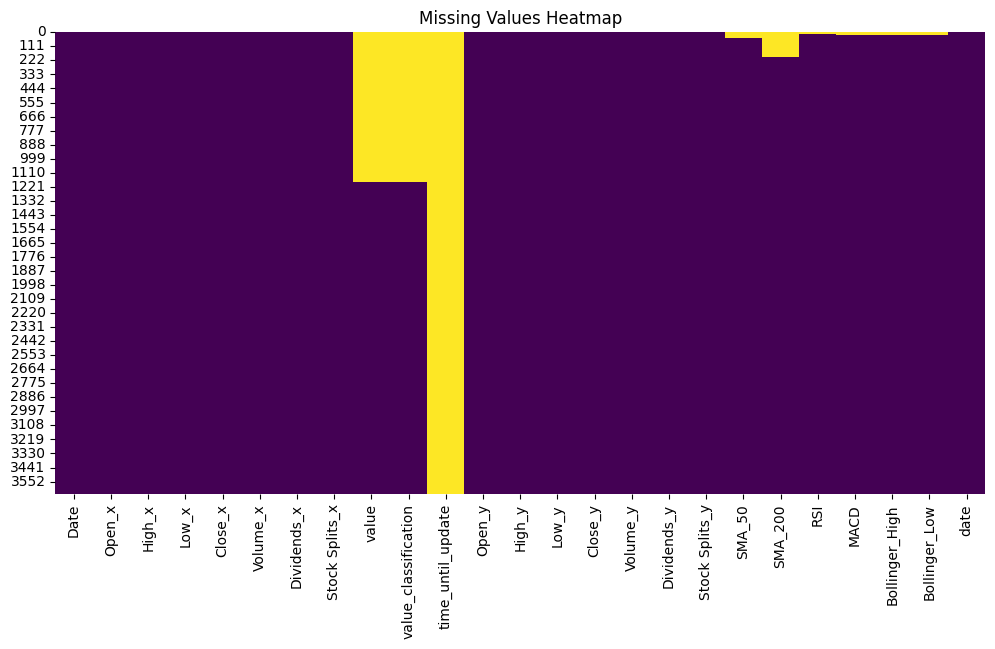

In [33]:
# Check for missing values
missing_values = combined_df.isnull().sum()
print(missing_values)

# Visualize missing values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(combined_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


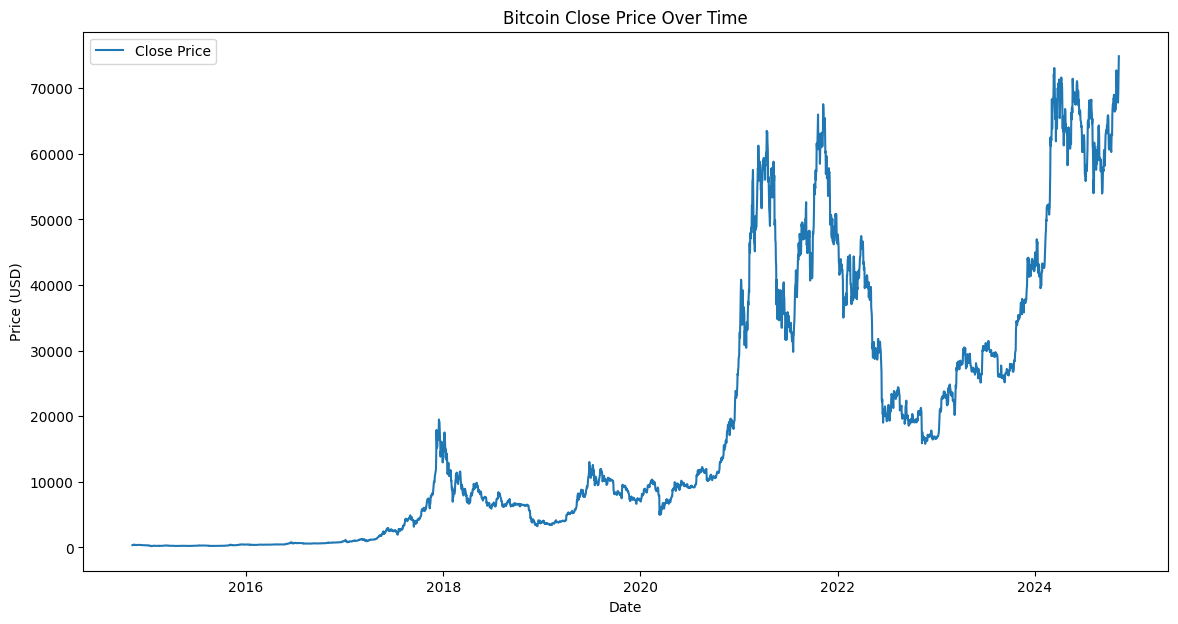

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(combined_df['Date'], combined_df['Close_x'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Close Price Over Time')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


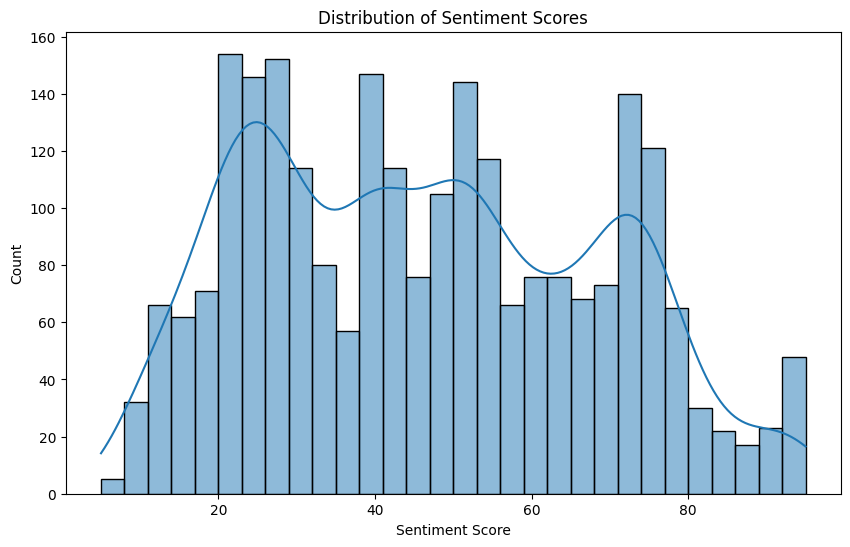

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['value'], bins=30, kde=True)
plt.xlabel('Sentiment Score')
plt.title('Distribution of Sentiment Scores')
plt.show()


In [39]:
# Map sentiment values to numeric scores
sentiment_mapping = {'Fear': 0, 'Neutral': 50, 'Greed': 100}
combined_df['value'] = combined_df['value'].map(sentiment_mapping)

In [67]:
# Map sentiment values to numeric scores
sentiment_mapping = {
    'Fear': 25,
    'Extreme Fear': 0,
    'Neutral': 50,
    'Greed': 75,
    'Extreme Greed': 100
}
combined_df['value_classification'] = combined_df['value_classification'].map(sentiment_mapping)


In [68]:
# Model parameters: specifying the model name to use
model_name = 'google/gemma-2-2b'